<font size=6><b>Bike Sharing Demand - ML

<img src="./logo.png">
* ref : https://www.kaggle.com/competitions/bike-sharing-demand/data <br>
* ref : https://dacon.io/competitions/official/235985/data

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


sns.set()

#-------------------- 차트 관련 속성 (한글처리, 그리드) -----------
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

#-------------------- 주피터 , 출력결과 넓이 늘리기 ---------------
# from IPython.core.display import display, HTML
from IPython.display import display, HTML

display(HTML("<style>.container{width:100% !important;}</style>"))
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)

import warnings
warnings.filterwarnings(action='ignore')

In [2]:

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error


from sklearn.ensemble     import RandomForestRegressor
from sklearn.tree         import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
# ---- 추가 모델
from sklearn.ensemble     import AdaBoostRegressor, VotingRegressor
from xgboost              import XGBRegressor
from lightgbm             import LGBMRegressor



# Data Load

In [3]:
train = pd.read_csv("./train.csv", parse_dates=['datetime'])
test  = pd.read_csv("./test.csv" , parse_dates=['datetime'])

In [4]:
df_list = [train, test]
for df in df_list:
    df.rename(columns = {'datetime' : 'regdate', 'count' : 'regcount'}, inplace = True)
    df.columns = df.columns.str.lower()
    print(df.info())    
    print("====="*10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   regdate     10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  regcount    10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dty

# Feature Engineering

In [5]:
train.columns

Index(['regdate', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'regcount'],
      dtype='object')

In [6]:
for col in train.columns:
    print(col, train[col].nunique())

regdate 10886
season 4
holiday 2
workingday 2
weather 4
temp 49
atemp 60
humidity 89
windspeed 28
casual 309
registered 731
regcount 822


* 22

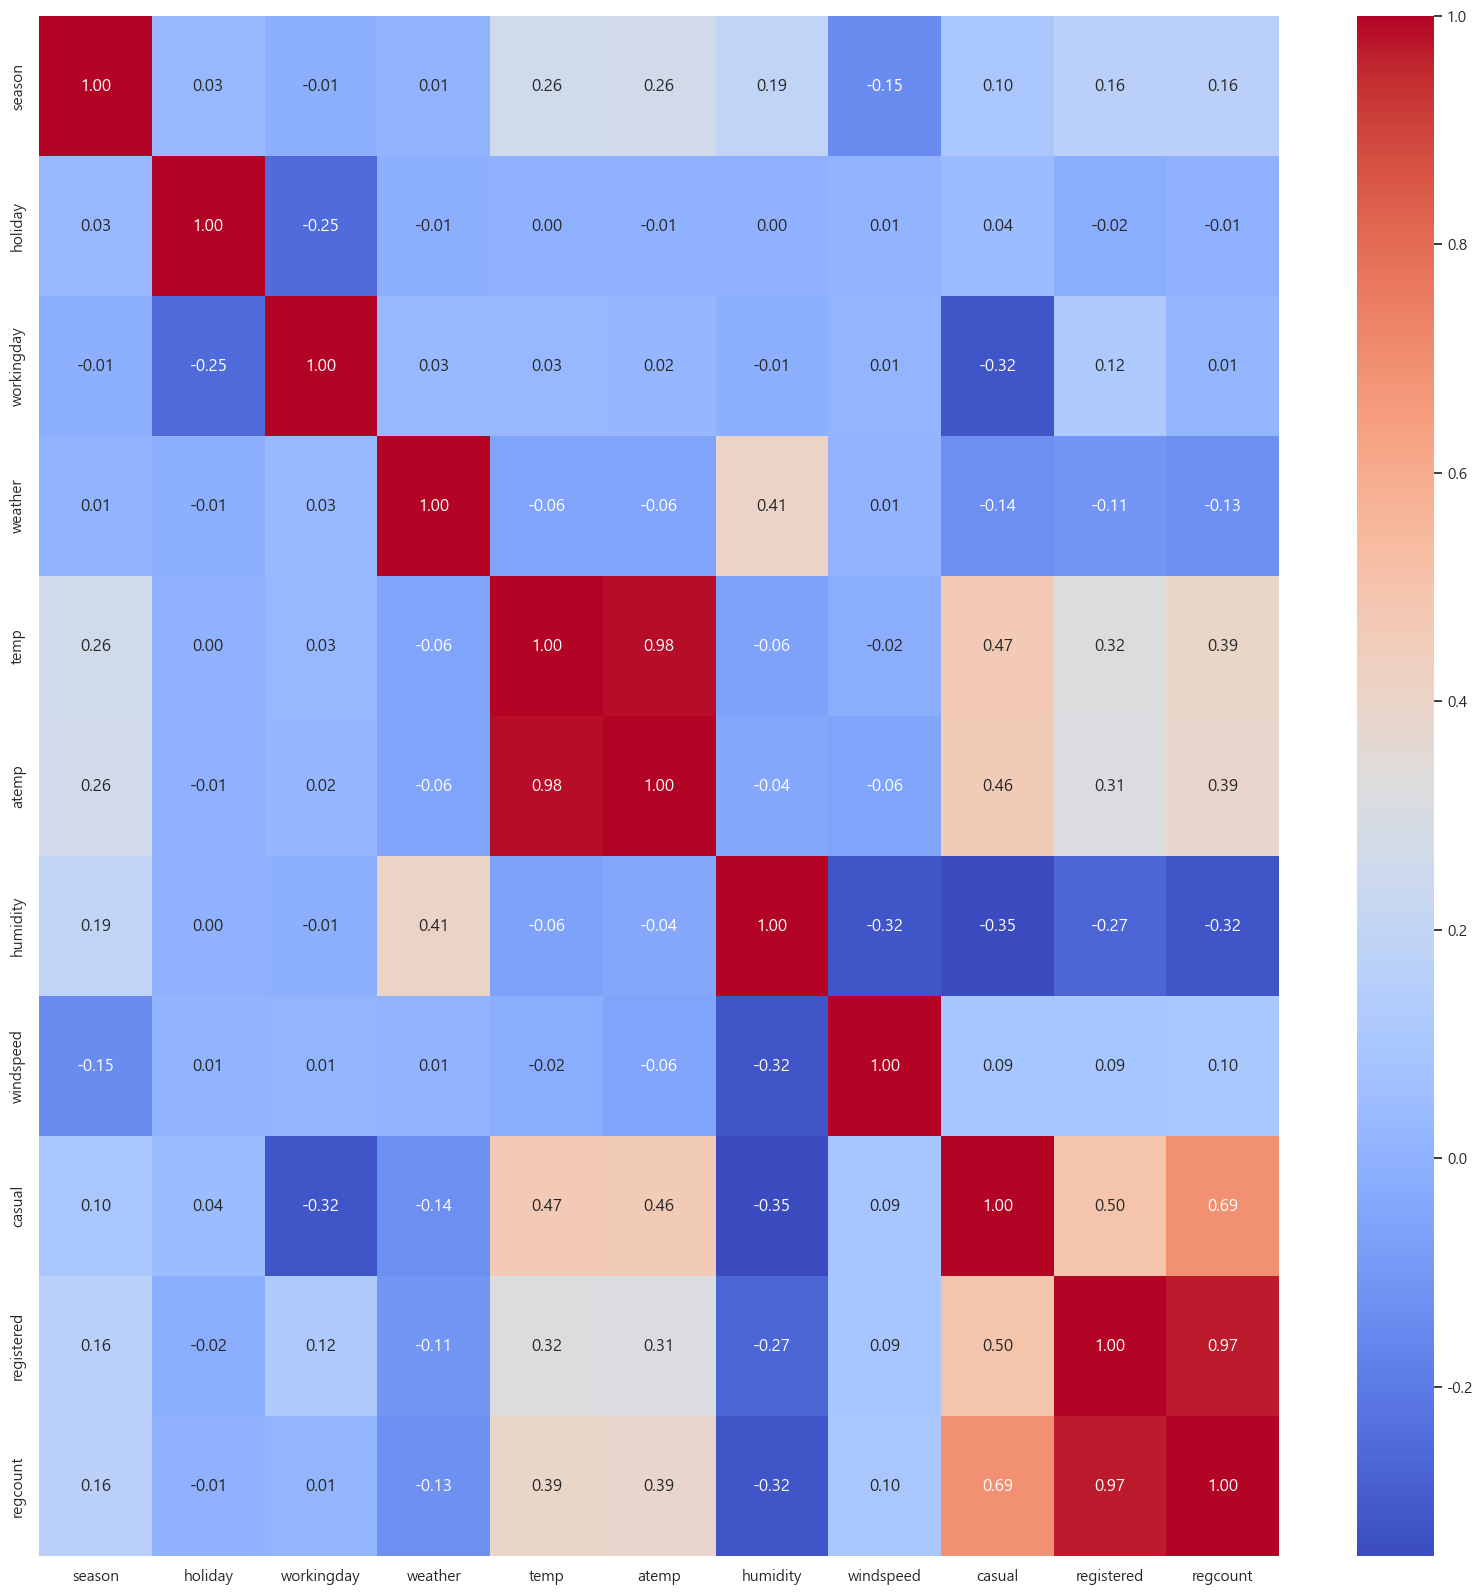

In [7]:
plt.figure(figsize=(20,20))
sns.heatmap(train.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.show()


In [8]:
# plt.figure(figsize=(20,20))
# sns.heatmap(df[['casual', 'registered', 
#        'h_0', 'h_1','h_2', 'h_3', 'h_4', 'h_5', 'h_6', 'h_7', 'h_8', 'h_9', 'h_10', 'h_11',
#        'h_12', 'h_13', 'h_14', 'h_15', 'h_16', 'h_17', 'h_18', 'h_19', 'h_20',
#        'h_21', 'h_22', 'h_23',
#        #          ,'m_1','m_2', 'm_3', 'm_4', 'm_5', 'm_6', 'm_7', 'm_8', 'm_9', 'm_10', 'm_11',
#        # 'm_12', 'y_2011', 'y_2012',  'w_0', 'w_1', 'w_2', 'w_3', 'w_4', 'w_5', 'w_6',
#        # ,'holiday', 'workingday',    
#        # 'day_type_0', 'day_type_1', 'day_type_2'
#         ]].corr(), annot=True, fmt=".2f", cmap="coolwarm")
# plt.show()


## windspeed 0 채우기

In [9]:
train.shape, test.shape

((10886, 12), (6493, 9))

In [10]:
def my_fill_windspeed(df):
    target  = df[['regcount','casual','registered', 'regdate']]
    df = df.drop(['regcount','casual','registered','regdate'], axis=1)
    
    df1   = df[df['windspeed'] != 0]
    y_df1 = df1['windspeed']
    X_df1 = df1.drop('windspeed', axis=1)
    
    rf = LGBMRegressor(random_state=0)  #RandomForestRegressor(random_state=11)
    X_df1_8, X_df1_2, y_df1_8, y_df1_2 = train_test_split(X_df1, y_df1, test_size=0.2, random_state=11)
    rf.fit(X_df1_8, y_df1_8)
    
    pred = rf.predict(X_df1_2)
    mse_score = mean_squared_error(y_df1_2, pred)
    print("RMSE : ", np.sqrt(mse_score) )

    df0 = df[df['windspeed'] == 0]
    y_df0 = df0['windspeed']
    X_df0 = df0.drop('windspeed', axis=1)
    pred = rf.predict(X_df0)
    widx = X_df0.index.values
    df.loc[widx, 'windspeed'] = pred
    
    return pd.concat([df, target], axis=1)

In [11]:
train.columns, test.columns

(Index(['regdate', 'season', 'holiday', 'workingday', 'weather', 'temp',
        'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'regcount'],
       dtype='object'),
 Index(['regdate', 'season', 'holiday', 'workingday', 'weather', 'temp',
        'atemp', 'humidity', 'windspeed'],
       dtype='object'))

In [12]:
df = pd.concat([train, test], axis=0, ignore_index=True)
train_idx = df.iloc[:train.shape[0], :].index
test_idx  = df.iloc[train.shape[0]:, :].index
#---------------------------------
df = my_fill_windspeed(df)
#---------------------------------
train = df.loc[train_idx]
test  = df.loc[test_idx]
test = test.drop(['casual', 'registered', 'regcount'], axis=1)
test = test.reset_index(drop=True)

RMSE :  5.427882362943079


In [13]:
train.columns, test.columns

(Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
        'humidity', 'windspeed', 'regcount', 'casual', 'registered', 'regdate'],
       dtype='object'),
 Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
        'humidity', 'windspeed', 'regdate'],
       dtype='object'))

In [14]:
train.shape, test.shape

((10886, 12), (6493, 9))

## 피쳐가공
* 파생 피쳐: regdate, day_type
* 휴무처리 : holiday, workingday
* 아웃라이어 : weather, temp, windspeed
* 로그스케일링(연속형) : 'temp', 'atemp','humidity', 'windspeed'
* 원핫인코딩(이산형) :  'season', 'weather','m', 'y', 'h', 'w', 'day_type'
* 다중공선 : ('temp', 'atemp') ('season', 'm') ('w', 'day_type')
* 불필요컬럼 삭제 :'d'

In [15]:
df_list = [train, test]
df_name = ['train', 'test']
for i, df in enumerate(df_list):
    df['y'] = df['regdate'].dt.year
    df['m'] = df['regdate'].dt.month
    df['d'] = df['regdate'].dt.day
    df['h'] = df['regdate'].dt.hour
    df['w'] = df['regdate'].dt.dayofweek
    #df['woy'] = df['regdate'].dt.weekofyear
    
    
    df['day_type'] = 0
    df['day_type'] = np.where( (df['holiday']==0) & (df['workingday'] == 1),   1,  df['day_type'])
    df['day_type'] = np.where( (df['holiday']==1) & (df['workingday'] == 0),   2,  df['day_type'])
    
    df['peak']   = df[['h', 'workingday']].apply(lambda x: (0, 1)[(x['workingday'] == 1 and  ( x['h'] == 8 or 17 <= x['h'] <= 18 or 12 <= x['h'] <= 12)) or (x['workingday'] == 0 and  10 <= x['h'] <= 19)], axis = 1)
    df['ideal']  = df[['temp', 'windspeed']].apply(lambda x: (0, 1)[x['temp'] > 27 and x['windspeed'] < 30], axis = 1)
    df['sticky'] = df[['humidity', 'workingday']].apply(lambda x: (0, 1)[x['workingday'] == 1 and x['humidity'] >= 60], axis = 1)
    
    #sandy
    df['holiday'] = df[['m', 'd', 'holiday', 'y']].apply(lambda x: (x['holiday'], 1)[x['y'] == 2012 and x['m'] == 10 and (x['m'] in [30])], axis = 1)
    #christmas day and others
    df['holiday'] = df[['m', 'd', 'holiday']].apply(lambda x: (x['holiday'], 1)[x['m'] == 12 and (x['m'] in [24, 26, 31])], axis = 1)
    df['workingday'] = df[['m', 'd', 'workingday']].apply(lambda x: (x['workingday'], 0)[x['m'] == 12 and x['m'] in [24, 31]], axis = 1)
    
    
    if i == 0 : # 아웃라이어 : train만 삭제
        #------------------------------------------------
        # windspeed는 0채우기 후 아웃라이어로 한꺼번에 이상치 삭제
        # 아웃라이어 삭제 : 주의주의주의 train만 지운다
        # df == train 넣고 호출
        #------------------------------------------------
        del_idx_list = []
        #idx = df[df['weather']==4].index
        #del_idx_list.extend(idx)
        idx = df[df['temp']>40].index
        del_idx_list.extend(idx)
        idx = df[df['windspeed']>50].index
        del_idx_list.extend(idx)
        df.drop(del_idx_list, axis=0, inplace=True)

    
    #---------(연속형피쳐:로그스케일링) ---------------
    # 'temp', 'atemp','humidity', 'windspeed'
    #------------------------------------------------
    df['temp']      = np.log1p( df['temp'] )
    df['atemp']     = np.log1p( df['atemp'] )
    df['humidity']  = np.log1p( df['humidity'] )
    df['windspeed'] = np.log1p( df['windspeed'] )
    
    #------------------------------------------------
    # 다중공선
    # 'temp', 'atemp'
    # 'season', 'm'
    # 'w', 'day_type'
    #------------------------------------------------
    df = df.drop(['atemp'], axis=1)
    # X = X.drop(['season'], axis=1)
    # X = X.drop(['day_type'], axis=1)
    
    
    #------------------------------------------------
    # 이산형 피쳐 원핫인코딩
    # ['season', 'weather','m', 'y', 'h', 'w', 'day_type']
    df = pd.get_dummies(df, columns=['season', 'weather','m', 'y', 'h', 'w', 'day_type'])
    
    #------------------------------------------------
    #X = df.drop(['regcount','casual','registered'], axis=1)
    df.drop('d', axis=1, inplace=True)
    df = df.set_index('regdate')
    
    #------------------------------------------------
    #print(df.info())
    print(df_name[i])
    globals()[df_name[i]] = df.copy()

train
test


In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10881 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 67 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   holiday     10881 non-null  int64  
 1   workingday  10881 non-null  int64  
 2   temp        10881 non-null  float64
 3   humidity    10881 non-null  float64
 4   windspeed   10881 non-null  float64
 5   regcount    10881 non-null  float64
 6   casual      10881 non-null  float64
 7   registered  10881 non-null  float64
 8   peak        10881 non-null  int64  
 9   ideal       10881 non-null  int64  
 10  sticky      10881 non-null  int64  
 11  season_1    10881 non-null  uint8  
 12  season_2    10881 non-null  uint8  
 13  season_3    10881 non-null  uint8  
 14  season_4    10881 non-null  uint8  
 15  weather_1   10881 non-null  uint8  
 16  weather_2   10881 non-null  uint8  
 17  weather_3   10881 non-null  uint8  
 18  weather_4   10881 non-null  uin

In [17]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6493 entries, 2011-01-20 00:00:00 to 2012-12-31 23:00:00
Data columns (total 64 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   holiday     6493 non-null   int64  
 1   workingday  6493 non-null   int64  
 2   temp        6493 non-null   float64
 3   humidity    6493 non-null   float64
 4   windspeed   6493 non-null   float64
 5   peak        6493 non-null   int64  
 6   ideal       6493 non-null   int64  
 7   sticky      6493 non-null   int64  
 8   season_1    6493 non-null   uint8  
 9   season_2    6493 non-null   uint8  
 10  season_3    6493 non-null   uint8  
 11  season_4    6493 non-null   uint8  
 12  weather_1   6493 non-null   uint8  
 13  weather_2   6493 non-null   uint8  
 14  weather_3   6493 non-null   uint8  
 15  weather_4   6493 non-null   uint8  
 16  m_1         6493 non-null   uint8  
 17  m_2         6493 non-null   uint8  
 18  m_3         6493 non-null   uint

# 학습

## 타켓 선정
* 답안지 : count 제출
* regcount(A패턴)  = registered(A2패턴) + casual (B패턴) 
* <font color=red><b>registered(A2패턴) + casual (B패턴)  --> 이 값을 답안으로 제출

## 최종피쳐 선정

In [18]:
train.columns

Index(['holiday', 'workingday', 'temp', 'humidity', 'windspeed', 'regcount',
       'casual', 'registered', 'peak', 'ideal', 'sticky', 'season_1',
       'season_2', 'season_3', 'season_4', 'weather_1', 'weather_2',
       'weather_3', 'weather_4', 'm_1', 'm_2', 'm_3', 'm_4', 'm_5', 'm_6',
       'm_7', 'm_8', 'm_9', 'm_10', 'm_11', 'm_12', 'y_2011', 'y_2012', 'h_0',
       'h_1', 'h_2', 'h_3', 'h_4', 'h_5', 'h_6', 'h_7', 'h_8', 'h_9', 'h_10',
       'h_11', 'h_12', 'h_13', 'h_14', 'h_15', 'h_16', 'h_17', 'h_18', 'h_19',
       'h_20', 'h_21', 'h_22', 'h_23', 'w_0', 'w_1', 'w_2', 'w_3', 'w_4',
       'w_5', 'w_6', 'day_type_0', 'day_type_1', 'day_type_2'],
      dtype='object')

<pre>
타겟(1) : 'casual' + 'registered'
타겟(2) : 'regcount'


'd' 피쳐 삭제
('m', 'h'),  'y', 'd' -->'w'


(+)3개 : 'holiday', 'workingday', 'day_type'
(+)2개 : 'holiday', 'workingday'
(+)1개 : 'day_type'


'weather', 'humidity',  'season', 
(+)'windspeed' : 'h' 비례? / 'm' 반비례?


다중공선 : (상관계수가 높은 경우)
'regcount' 'registered' 'casual' : 0.97  --> 'regcount' vs. 'registered'+'casual'
'temp' 'atemp'                   : 0.98  --> 'atemp' drop

선택적으로 모델에 적용
(+)'w' 'day_type' : -0.78
(+)'season' 'm'   : 0.97


* ('m', 'h'),  'y', 'w', 'weather', 'humidity',  'season', 'temp'
* (+)'windspeed'
* (+)('holiday', 'workingday'), ('day_type')
* (+)('w' 'day_type') : -0.78
* (+)('m') 'season'    : 0.97


## 학습 & 평가
* ref : https://suboptimal.wiki/explanation/mse/

*  $ RMSLE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{log(Y_i+1) - log(\hat{Y_i}+1)}{N}\Big)^2}}$

## 공통함수

In [19]:
# ! pip install xgboost
# ! pip install lightgbm 

* class sklearn.linear_model.Ridge(alpha=1.0, *, fit_intercept=True, copy_X=True, max_iter=None, tol=0.0001, solver='auto', positive=False, random_state=None)
* class sklearn.linear_model.Lasso(alpha=1.0, *, fit_intercept=True, precompute=False, copy_X=True, max_iter=1000, tol=0.0001, warm_start=False, positive=False, random_state=None, selection='cyclic')

* https://towardsdatascience.com/custom-implementation-of-feature-importance-for-your-voting-classifier-model-859b573ce0e0
* [bagging vs boosting] : http://egloos.zum.com/incredible/v/7478090
* [eval plot] https://hyemin-kim.github.io/2020/08/04/S-Python-sklearn4/#2-%ED%8F%89%EA%B0%80-%EC%A7%80%ED%91%9C-%EB%A7%8C%EB%93%A4%EA%B8%B0

In [20]:
modelsss = Ridge(alpha=1.0, random_state=0)
modelsss.__class__.__name__

'Ridge'

In [21]:
def my_view_chart(model_name, model, X_train):
    if model_name == "RIDGE" :
        ax1 = plt.subplot(4,1,1)
        s = pd.Series(model.coef_, index=X_train.columns).sort_values()
        sns.barplot(x=s.values, y=s.index, ax=ax1)
        plt.show()
    elif model_name == "RF" :
        ax2 = plt.subplot(4,1,2)
        s = pd.Series(model.feature_importances_, index=X_train.columns).sort_values()
        sns.barplot(x=s.values, y=s.index, ax=ax2)
        plt.show()
    elif model_name == "XGB" :
        ax3 = plt.subplot(4,1,3)
        # Weight, Gain, Cover
        s = pd.Series(model.get_booster().get_score(importance_type='weight'), index=X_train.columns).sort_values()
        sns.barplot(x=s.values, y=s.index, ax=ax3)
        plt.show()
    elif model_name == "LGBM" :
        ax4 = plt.subplot(4,1,4)  
        # Gain, Split
        #s = pd.Series(model.booster_.faeture_importance(importance_type="gain"), index=X_train.columns).sort_values()
        s = pd.Series(model.feature_importances_, index=X_train.columns).sort_values()
        sns.barplot(x=s.values, y=s.index, ax=ax4)
        plt.show()
            

In [22]:
def my_fit_score(df, chart_view=False) :
    model_list = [ 
                   #("RIDGE"  , Ridge(alpha=1.0, random_state=0)),
                   #("LASSO"  , Lasso(alpha=1.0, random_state=0)),
                   ("DTR"    , DecisionTreeRegressor(random_state=0)),
                   ("RF"     , RandomForestRegressor(random_state=0)),
                   #("LR"     , LinearRegression()                   ),
                   #("ABOOST" , AdaBoostRegressor(random_state=0)                  ),
                   ("XGB"    , XGBRegressor(random_state=0)                       ),   #booster=gblinear
                   ("LGBM"   , LGBMRegressor(random_state=0)                      ),
                   # model.booster().get_score(importance_type='weight')
                   ("VR-XGB-LGBM"  , VotingRegressor([("XGB", XGBRegressor(random_state=0)), ("LGBM", LGBMRegressor(random_state=0))]) ) ,
                   ("VR-RF-LGBM"   , VotingRegressor([("DTR", RandomForestRegressor(random_state=0)), ("LGBM", LGBMRegressor(random_state=0))]) )
                 ]
   
    
    #---------(타켓피쳐:로그스케일링) -----------
    # y_c = df['casual'] 
    # y_r = df['registered'] 
    y_c = np.log1p( df['casual'] )
    y_r = np.log1p( df['registered'] )
    # print(y_c[:5], y_r[:5])
    
    X = df.drop(['regcount','casual','registered'], axis=1)
    

    for tpl in model_list :
        print( tpl[0] )         
        model = tpl[1]
        X_train, X_test, y_train, y_r_test = train_test_split(X, y_r, random_state=0, test_size=0.2)
        model.fit(X_train, y_train)  
        #------------------------------------------------
        # feature_importance 차트 그리기
        if bool(chart_view) : 
            my_view_chart(tpl[0], model, X_train)
        #------------------------------------------------
        y_r_pred = model.predict(X_test)
        
        
        model = tpl[1]
        X_train, X_test, y_train, y_c_test = train_test_split(X, y_c, random_state=0, test_size=0.2)
        model.fit(X_train, y_train)
        y_c_pred = model.predict(X_test)
        
        
        #---------(타켓피쳐:로그스케일링) 복원-----------
        y_pred_comb = np.expm1(y_r_pred)+np.expm1(y_c_pred)
        y_real_comb = np.expm1(y_r_test)+np.expm1(y_c_test)
        y_pred_comb[y_pred_comb < 0] = 0
        
        # print("yrtest", y_r_test[:5])
        # print("yctest", y_c_test[:5])
        # print("ypred", y_pred_comb[:5])
        msle_score = mean_squared_log_error(y_real_comb, y_pred_comb)

        print("RMSLE: ", np.sqrt(msle_score)) 
        print("-"*30)
        

## 점수보기
* RF  
RMSLE:  0.3288546947603633  : 원본  
RMSLE:  0.327712532218228   : 풍속채우기  
RMSLE:  0.3029460779805034  : 스케일링  

* VR-XGB-LGBM  
RMSLE:  0.2839304212238602  : 타겟스케일링  
RMSLE:  0.28362762650351697 : 연속형스케일링  
RMSLE : 0.28753884621648423 : atemp 다중공선 삭제  
RMSLE:  0.3094906507392463  : 원핫인코딩  
RMSLE:  0.3050329198155958  : 아웃라이어
* VR-XGB-LGBM  
RMSLE:  0.3021050186280649  : 아웃라이어

In [23]:
my_fit_score(train)
# my_fit_score(train, chart_view=True)

DTR
RMSLE:  0.39513136629600504
------------------------------
RF
RMSLE:  0.30527037468363344
------------------------------
XGB
RMSLE:  0.30162506914820986
------------------------------
LGBM
RMSLE:  0.29414778468571606
------------------------------
VR-XGB-LGBM
RMSLE:  0.28915645477161256
------------------------------
VR-RF-LGBM
RMSLE:  0.28955359080389625
------------------------------


# 평가 검증

<pre>
RF
RMSLE:  0.3240882615968124
------------------------------
XGB
RMSLE:  0.31444042937265204
------------------------------
LGBM
RMSLE:  0.3084384282190159

## X, y 분리

In [24]:
print(train.shape)
train.columns

(10881, 67)


Index(['holiday', 'workingday', 'temp', 'humidity', 'windspeed', 'regcount',
       'casual', 'registered', 'peak', 'ideal', 'sticky', 'season_1',
       'season_2', 'season_3', 'season_4', 'weather_1', 'weather_2',
       'weather_3', 'weather_4', 'm_1', 'm_2', 'm_3', 'm_4', 'm_5', 'm_6',
       'm_7', 'm_8', 'm_9', 'm_10', 'm_11', 'm_12', 'y_2011', 'y_2012', 'h_0',
       'h_1', 'h_2', 'h_3', 'h_4', 'h_5', 'h_6', 'h_7', 'h_8', 'h_9', 'h_10',
       'h_11', 'h_12', 'h_13', 'h_14', 'h_15', 'h_16', 'h_17', 'h_18', 'h_19',
       'h_20', 'h_21', 'h_22', 'h_23', 'w_0', 'w_1', 'w_2', 'w_3', 'w_4',
       'w_5', 'w_6', 'day_type_0', 'day_type_1', 'day_type_2'],
      dtype='object')

In [25]:
train.head(2)

,holiday,workingday,temp,humidity,windspeed,regcount,casual,registered,peak,ideal,sticky,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12,y_2011,y_2012,h_0,h_1,h_2,h_3,h_4,h_5,h_6,h_7,h_8,h_9,h_10,h_11,h_12,h_13,h_14,h_15,h_16,h_17,h_18,h_19,h_20,h_21,h_22,h_23,w_0,w_1,w_2,w_3,w_4,w_5,w_6,day_type_0,day_type_1,day_type_2
regdate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,0,0,2.383243,4.406719,1.933883,16.0,3.0,13.0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
2011-01-01 01:00:00,0,0,2.304583,4.394449,1.976391,40.0,8.0,32.0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0


In [26]:
train.describe()

,holiday,workingday,temp,humidity,windspeed,regcount,casual,registered,peak,ideal,sticky,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12,y_2011,y_2012,h_0,h_1,h_2,h_3,h_4,h_5,h_6,h_7,h_8,h_9,h_10,h_11,h_12,h_13,h_14,h_15,h_16,h_17,h_18,h_19,h_20,h_21,h_22,h_23,w_0,w_1,w_2,w_3,w_4,w_5,w_6,day_type_0,day_type_1,day_type_2
count,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000,10881.00000,10881.000000,10881.000000,10881.00000,10881.000000,10881.00000,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000,10881.000000
mean,0.028582,0.681095,2.974899,4.083434,2.622525,191.569433,35.997978,155.571455,0.247128,0.236192,0.361823,0.246669,0.251172,0.250896,0.251264,0.660693,0.260454,0.078761,0.000092,0.081243,0.082621,0.082805,0.08354,0.083816,0.083816,0.08354,0.083816,0.08354,0.083724,0.083724,0.083816,0.497932,0.502068,0.041816,0.041632,0.041173,0.039794,0.040621,0.041540,0.041816,0.041816,0.041816,0.041816,0.041816,0.041816,0.041908,0.041908,0.041908,0.041816,0.041816,0.041816,0.041816,0.041908,0.041908,0.041908,0.041908,0.041908,0.142542,0.141347,0.142542,0.142726,0.140520,0.145391,0.144932,0.290323,0.681095,0.028582
std,0.166636,0.466073,0.425546,0.381993,0.433482,181.167420,49.943972,151.064148,0.431362,0.424761,0.480550,0.431092,0.433707,0.433549,0.433760,0.473496,0.438903,0.269378,0.009587,0.273220,0.275321,0.275600,0.27671,0.277124,0.277124,0.27671,0.277124,0.27671,0.276986,0.276986,0.277124,0.500019,0.500019,0.200178,0.199756,0.198699,0.195484,0.197420,0.199545,0.200178,0.200178,0.200178,0.200178,0.200178,0.200178,0.200388,0.200388,0.200388,0.200178,0.200178,0.200178,0.200178,0.200388,0.200388,0.200388,0.200388,0.200388,0.349621,0.348395,0.349621,0.349809,0.347542,0.352511,0.352048,0.453932,0.466073,0.166636
min,0.000000,0.000000,0.598837,0.000000,1.792236,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,2.704042,3.871201,2.302395,42.000000,4.000000,36.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,3.068053,4.143135,2.638914,145.000000,17.000000,118.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.

In [27]:
train.shape, train.columns

((10881, 67),
 Index(['holiday', 'workingday', 'temp', 'humidity', 'windspeed', 'regcount',
        'casual', 'registered', 'peak', 'ideal', 'sticky', 'season_1',
        'season_2', 'season_3', 'season_4', 'weather_1', 'weather_2',
        'weather_3', 'weather_4', 'm_1', 'm_2', 'm_3', 'm_4', 'm_5', 'm_6',
        'm_7', 'm_8', 'm_9', 'm_10', 'm_11', 'm_12', 'y_2011', 'y_2012', 'h_0',
        'h_1', 'h_2', 'h_3', 'h_4', 'h_5', 'h_6', 'h_7', 'h_8', 'h_9', 'h_10',
        'h_11', 'h_12', 'h_13', 'h_14', 'h_15', 'h_16', 'h_17', 'h_18', 'h_19',
        'h_20', 'h_21', 'h_22', 'h_23', 'w_0', 'w_1', 'w_2', 'w_3', 'w_4',
        'w_5', 'w_6', 'day_type_0', 'day_type_1', 'day_type_2'],
       dtype='object'))

In [28]:
test.shape, test.columns

((6493, 64),
 Index(['holiday', 'workingday', 'temp', 'humidity', 'windspeed', 'peak',
        'ideal', 'sticky', 'season_1', 'season_2', 'season_3', 'season_4',
        'weather_1', 'weather_2', 'weather_3', 'weather_4', 'm_1', 'm_2', 'm_3',
        'm_4', 'm_5', 'm_6', 'm_7', 'm_8', 'm_9', 'm_10', 'm_11', 'm_12',
        'y_2011', 'y_2012', 'h_0', 'h_1', 'h_2', 'h_3', 'h_4', 'h_5', 'h_6',
        'h_7', 'h_8', 'h_9', 'h_10', 'h_11', 'h_12', 'h_13', 'h_14', 'h_15',
        'h_16', 'h_17', 'h_18', 'h_19', 'h_20', 'h_21', 'h_22', 'h_23', 'w_0',
        'w_1', 'w_2', 'w_3', 'w_4', 'w_5', 'w_6', 'day_type_0', 'day_type_1',
        'day_type_2'],
       dtype='object'))

In [29]:
y_train_c = train['casual']
y_train_r = train['registered']
X_train = train.drop(['regcount', 'casual', 'registered'], axis=1)
X_train.shape, y_train_c.shape, y_train_r.shape

((10881, 64), (10881,), (10881,))

## 평가함수

In [30]:
from sklearn.metrics import make_scorer
def my_rmsle_func(y_true, y_pred):    
    msle_score = mean_squared_log_error(y_true, y_pred)
    # print("RMSLE: ", np.sqrt(msle_score)) 
    return np.sqrt(msle_score)

myfunc = make_scorer(my_rmsle_func, greater_is_better=False)  #낮은값 선택

## RandomForestRegressor

### casual 예측

In [31]:
kf = KFold(n_splits=5, shuffle=True, random_state=11)
model = RandomForestRegressor(random_state=0)  
mydic = {"min_samples_split":[1,2], "min_samples_leaf":[1,2]}
models_rf = GridSearchCV(model, scoring=myfunc, cv=kf, param_grid = mydic)
models_rf.fit(X_train, np.log1p(y_train_c))
print(models_rf.best_params_)
print(models_rf.best_score_)  

# 예측
best_model = models_rf.best_estimator_
pred_c_rf = best_model.predict(test)
print(pred_c_rf[:5])

{'min_samples_leaf': 2, 'min_samples_split': 1}
-0.22401534459845102
[1.19313688 0.77430622 1.26263065 0.34603675 0.01663553]


### registered 예측

In [32]:
kf = KFold(n_splits=5, shuffle=True, random_state=11)
model = RandomForestRegressor(random_state=0)  
mydic = {"min_samples_split":[1,2], "min_samples_leaf":[1,2]}
models_rf = GridSearchCV(model, scoring=myfunc, cv=kf, param_grid = mydic)
models_rf.fit(X_train, np.log1p(y_train_r))
print(models_rf.best_params_)
print(models_rf.best_score_)  

# 예측
best_model = models_rf.best_estimator_
pred_r_rf = best_model.predict(test)
print(pred_r_rf[:5])

{'min_samples_leaf': 2, 'min_samples_split': 1}
-0.08929503634825514
[2.22565176 1.57161678 1.06350859 1.0760182  1.03738179]


## XGBRegressor
* ref : https://xgboost.readthedocs.io/en/stable/python/python_api.html#module-xgboost.sklearn

### casual 예측

In [33]:
kf = KFold(n_splits=5, shuffle=True, random_state=11)
model = XGBRegressor(random_state=0)  
mydic = {"learning_rate":[0.001, 0.01, 0.1, 0.3], "n_estimators":[100,200,300]}
models_xgb = GridSearchCV(model, scoring=myfunc, cv=kf, param_grid = mydic)
models_xgb.fit(X_train, np.log1p(y_train_c))
print(models_xgb.best_params_)
print(models_xgb.best_score_)      

# 예측
best_model = models_xgb.best_estimator_
pred_c_xgb = best_model.predict(test)
print(pred_c_xgb[:5])

{'learning_rate': 0.01, 'n_estimators': 300}
-0.25121734463173573
[1.1682856  0.94843847 0.9108432  0.8280098  0.42309403]


### registered 예측

In [34]:
kf = KFold(n_splits=5, shuffle=True, random_state=11)
model = XGBRegressor(random_state=0)  
mydic = {"learning_rate":[0.001, 0.01, 0.1, 0.3], "n_estimators":[100,200,300]}
models_xgb = GridSearchCV(model, scoring=myfunc, cv=kf, param_grid = mydic)
models_xgb.fit(X_train, np.log1p(y_train_r))
print(models_xgb.best_params_)
print(models_xgb.best_score_)   

# 예측
best_model = models_xgb.best_estimator_
pred_r_xgb = best_model.predict(test)
print(pred_r_xgb[:5])

{'learning_rate': 0.1, 'n_estimators': 100}
-0.08986214542712087
[2.3134341 1.7191383 1.3235322 1.1706604 1.1053602]


## LGBMRegressor

### casual 예측

In [35]:
kf = KFold(n_splits=5, shuffle=True, random_state=11)
model = LGBMRegressor(random_state=0)  
mydic = {"learning_rate":[0.001, 0.01, 0.1, 0.3], "n_estimators":[100,200,300]}
models_lgbm = GridSearchCV(model, scoring=myfunc, cv=kf, param_grid = mydic)
models_lgbm.fit(X_train, np.log1p(y_train_c))
print(models_lgbm.best_params_)
print(models_lgbm.best_score_)     

# 예측
best_model = models_lgbm.best_estimator_
pred_c_lgbm = best_model.predict(test)
print(pred_c_lgbm[:5])

{'learning_rate': 0.01, 'n_estimators': 300}
-0.2475746627336967
[1.27555367 1.02692384 1.00116455 0.83196462 0.58917053]


### registered 예측

In [36]:
kf = KFold(n_splits=5, shuffle=True, random_state=11)
model = LGBMRegressor(random_state=0)  
mydic = {"learning_rate":[0.001, 0.01, 0.1, 0.3], "n_estimators":[100,200,300]}
models_lgbm = GridSearchCV(model, scoring=myfunc, cv=kf, param_grid = mydic)
models_lgbm.fit(X_train, np.log1p(y_train_r))
print(models_lgbm.best_params_)
print(models_lgbm.best_score_)  

# 예측
best_model = models_lgbm.best_estimator_
pred_r_lgbm = best_model.predict(test)
print(pred_r_lgbm[:5])

{'learning_rate': 0.1, 'n_estimators': 200}
-0.08434895829208816
[2.39351698 1.68918991 1.19063743 1.11605551 1.02791861]


# 답안제출

## submit 파일 로드

In [37]:
sub_df = pd.read_csv("sampleSubmission.csv")
print(sub_df.shape)
sub_df.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


## pred

<pre>
rf   : 0.2240 0.0892
xgb  : 0.2512 0.0898
lgbm : 0.2475 0.0843

In [38]:
#---------(타켓피쳐:로그스케일링) 복원-----------
test_pred_rf   = np.expm1(pred_c_rf)     + np.expm1(pred_r_rf)
test_pred_xgb  = np.expm1(pred_c_xgb) + np.expm1(pred_r_xgb)
test_pred_lgbm = np.expm1(pred_c_lgbm)+ np.expm1(pred_r_lgbm)
test_pred_rf[test_pred_rf < 0] = 0
test_pred_xgb[test_pred_xgb < 0] = 0
test_pred_lgbm[test_pred_lgbm < 0] = 0

In [39]:
#sub_df['count'] = test_pred_rf*0.3 + test_pred_xgb*0.3 + test_pred_lgbm*0.4
#sub_df['count'] = np.expm1(pred_c) + np.expm1(pred_r_lgbm)
sub_df['count'] = test_pred_rf*0.2 + test_pred_lgbm*0.8
sub_df.head()

,datetime,count
0,2011-01-20 00:00:00,12.137487
1,2011-01-20 01:00:00,5.962746
2,2011-01-20 02:00:00,4.094746
3,2011-01-20 03:00:00,3.149780
4,2011-01-20 04:00:00,2.445906


In [40]:
desc_df = pd.concat([pd.DataFrame([test_pred_rf]).T.describe(),
           pd.DataFrame([test_pred_xgb]).T.describe(),
           pd.DataFrame([test_pred_lgbm]).T.describe(),
           sub_df['count'].describe(),
           train[['regcount']].describe(),
          ]
          , axis=1
          #, names=['rf','xgb','lgbm', 'train-regcount']
         )
desc_df.columns = ['rf','xgb','lgbm', 'w_pred', 'train-regcount']
desc_df

,rf,xgb,lgbm,w_pred,train-regcount
count,6493.000000,6493.000000,6493.000000,6493.000000,10881.000000
mean,184.112974,169.819214,177.426543,178.763829,191.569433
std,173.241977,158.130173,166.156307,167.250501,181.167420
min,1.451570,1.152584,1.350923,1.406183,1.000000
25%,40.976372,41.741909,40.559254,40.827032,42.000000
50%,143.222710,132.941376,135.517757,137.028091,145.000000
75%,271.936434,245.761719,262.523869,265.327600,284.000000
max,914.120971,815.450256,905.908214,903.879292,977.000000


## 답지 생성

In [41]:
sub_df.to_csv("v01.csv", index=False)
v = pd.read_csv("v01.csv")
v.head()

,datetime,count
0,2011-01-20 00:00:00,12.137487
1,2011-01-20 01:00:00,5.962746
2,2011-01-20 02:00:00,4.094746
3,2011-01-20 03:00:00,3.149780
4,2011-01-20 04:00:00,2.445906
